In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import time
from scipy.sparse import coo_matrix
from shapely.geometry import Point, LineString
import networkx as nx
import matplotlib.pyplot as plt
import folium
import warnings
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../src/models')
sys.path.append('../src/visualization')
sys.path.append('../src/features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork

['/Users/janhendrikwebert/maritime_route_prediction/notebooks', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python311.zip', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/lib-dynload', '', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/site-packages', '../src/models', '../src/visualization', '../src/features', '../visualization', '../features']


In [3]:
# read raw data from file
filename = '../data/processed/202204_points_stavanger_cleaned_meta_2M_dualSplit.parquet'
gdf = gpd.read_parquet(filename)

In [4]:
# Transform to desired CRS
# 4326 for WGS 84 (global) // 32632 for UTM 32N (Norway)
crs = 32632  # Coordinate reference system
gdf.to_crs(crs, inplace=True)  # Transformation
gdf.head()

mmsi  imo_nr  length      lon  \
date_time_utc                                                                   
2022-04-08 03:12:48  205209000_0_2022-04-08 03:12:48       0      51  5.36673   
2022-04-08 03:12:58  205209000_0_2022-04-08 03:12:48       0      51  5.36531   
2022-04-08 03:13:08  205209000_0_2022-04-08 03:12:48       0      51  5.36458   
2022-04-08 03:13:27  205209000_0_2022-04-08 03:12:48       0      51  5.36385   
2022-04-08 03:13:38  205209000_0_2022-04-08 03:12:48       0      51  5.36313   

                         lat   sog    cog  true_heading  nav_status  \
date_time_utc                                                         
2022-04-08 03:12:48  59.6732  10.6  225.9           225           0   
2022-04-08 03:12:58  59.6725  10.7  227.2           228           0   
2022-04-08 03:13:08  59.6722  10.6  228.8           230           0   
2022-04-08 03:13:27  59.6718  10.5  229.4           229           0   
2022-04-08 03:13:38  59.6715  10.5  225.2           223           0   

                     message_nr  bredde  dypgaaende skipstype skipsgruppe  \
date_time_utc                                                               
2022-04-08 03:12:48           1     NaN         NaN      None        None   
2022-04-08 03:12:58           1     NaN         NaN      None        None   
2022-04-08 03:13:08           1     NaN         NaN      None        None   
2022-04-08 03:13:27           1     NaN         NaN      None        None   
2022-04-08 03:13:38           1     NaN         NaN      None        None   

                    fartoynavn                        geometry      speed  
date_time_utc                                                              
2022-04-08 03:12:48       None  POINT (295416.506 6620618.919)  11.173331  
2022-04-08 03:12:58       None  POINT (295332.330 6620545.422)  11.173331  
2022-04-08 03:13:08       None  POINT (295289.421 6620514.299)   5.300198  
2022-04-08 03:13:27       None  POINT (295245.901 6620472.052)   3.191942  
2022-04-08 03:13:38       None  POINT (295203.553 6620440.899)   4.778771

In [5]:
# initialize maritime traffic network
network = MaritimeTrafficNetwork(gdf, crs)
network.get_trajectories_info()

Number of AIS messages: 1843903
Number of trajectories: 3848
Coordinate Reference System (CRS): EPSG:32632


In [6]:
# compute Douglas Peucker significant points
network.calc_significant_points_DP(tolerance=10)

Calculating significant turning points with Douglas Peucker algorithm (tolerance = 10) ...
Number of significant points detected: 138324 (7.50% of AIS messages)
Time elapsed: 1.44 minutes
Adding course over ground before and after each turn ...
Done. Time elapsed: 0.71 minutes


In [7]:
# detect waypoints using spatial clustering
method = 'HDBSCAN'      # 'DBSCAN' , 'HDBSCAN', 'OPTICS'
metric = 'mahalanobis'  # 'euclidean', 'mahalanobis', 'haversine'
min_samples = 25
min_cluster_size = 25
eps = 0.02
V = np.diag([1, 1, 0.005, 0.005])  # mahalanobis distance parameter matrix V = np.diag([0.01, 0.01, 1e6, 1e6]) 
network.calc_waypoints_clustering(method=method, min_samples=min_samples, min_cluster_size=min_cluster_size,
                                  eps=eps, metric=metric, V=V)

Calculating waypoints with HDBSCAN (min_samples = 25) ...
Distance metric: mahalanobis
600 clusters detected
Time elapsed: 2.37 minutes


In [8]:
# build network
#network.make_graph_from_waypoints(min_passages=2)
start = time.time()
n_clusters = len(network.waypoints)
coord_dict = {}
wps = network.waypoints.copy()
wps.set_geometry('convex_hull', inplace=True)
# for each trajectory, find the distance to all waypoints
for mmsi in network.significant_points.mmsi.unique():
    # find all intersections and close passages of waypoints
    trajectory = network.significant_points_trajectory.get_trajectory(mmsi)
    trajectory_segments = trajectory.to_line_gdf()
    distances = trajectory.distance(wps.convex_hull)
    mask = distances<50
    close_wps = wps[mask]
    # find temporal order  of waypoint passage
    passages = []
    for i in range(0, len(trajectory_segments)):
        segment = trajectory_segments.iloc[i]
        # distance of each segment to the selection of close waypoints
        distance_to_line = segment['geometry'].distance(close_wps.convex_hull)  # distance between line segment and waypoint convex hull     
        distance_to_origin = segment['geometry'].boundary.geoms[0].distance(close_wps.geometry)  # distance between first point of segment and waypoint centroids (needed for sorting)
        close_wps['distance_to_line'] = distance_to_line.tolist()
        close_wps['distance_to_origin'] = distance_to_origin.tolist()
        # angle between line segment and mean traffic direction in each waypoint
        close_wps['angle'] = np.abs((close_wps['cog_before'] + close_wps['cog_after'])/2 - segment['direction']) 
        # the line segment is associated with the waypoint, when its distance and angle is less than a threshold
        passed_wps = close_wps[(close_wps['distance_to_line']<50) & (close_wps['angle']<30)]
        passed_wps.sort_values(by='distance_to_origin', inplace=True)
        passages.extend(passed_wps['clusterID'].tolist())
    
    # create edges between subsequent passed waypoints
    if len(passages) > 1:  # subset needs to contain at least 2 waypoints
        for i in range(0, len(passages)-1):
            row = passages[i]
            col = passages[i+1]
            if row != col:  # no self loops
                if (row, col) in coord_dict:
                    coord_dict[(row, col)] += 1  # increase the edge weight for each passage
                else:
                    coord_dict[(row, col)] = 1  # create edge if it does not exist yet

In [9]:
# store adjacency matrix as sparse matrix in COO format
row_indices, col_indices = zip(*coord_dict.keys())
values = list(coord_dict.values())
A = coo_matrix((values, (row_indices, col_indices)), shape=(n_clusters, n_clusters))

# Construct a GeoDataFrame from graph edges
waypoints = network.waypoints.copy()
waypoints.set_geometry('geometry', inplace=True, crs=network.crs)
waypoint_connections = pd.DataFrame(columns=['from', 'to', 'geometry', 'direction', 'passages'])
for orig, dest, weight in zip(A.row, A.col, A.data):
    # add linestring as edge
    p1 = waypoints[waypoints.clusterID == orig].geometry
    p2 = waypoints[waypoints.clusterID == dest].geometry
    edge = LineString([(p1.x, p1.y), (p2.x, p2.y)])
    # compute the orientation fo the edge (COG)
    p1 = Point(waypoints[waypoints.clusterID == orig].lon, waypoints[waypoints.clusterID == orig].lat)
    p2 = Point(waypoints[waypoints.clusterID == dest].lon, waypoints[waypoints.clusterID == dest].lat)
    direction = geometry_utils.calculate_initial_compass_bearing(p1, p2)
    line = pd.DataFrame([[orig, dest, edge, direction, weight]], 
                        columns=['from', 'to', 'geometry', 'direction', 'passages'])
    waypoint_connections = pd.concat([waypoint_connections, line])
waypoint_connections = gpd.GeoDataFrame(waypoint_connections, geometry='geometry', crs=network.crs)
end = time.time()
print(f'Time elapsed: {(end-start)/60:.2f} minutes')

Time elapsed: 4.82 minutes


In [10]:
#network.make_graph_from_waypoints(min_passages=2)

In [11]:
mmsi = ['259386000_9_2022-04-02 05:00:51', '259386000_9_2022-04-02 05:30:45', '259386000_9_2022-04-02 06:01:20'] #'219347000_0'
#trajectory = network.trajectories.get_trajectory(mmsi)
#DP_trajectory = network.significant_points_trajectory.get_trajectory(mmsi)
DP_points = network.significant_points[network.significant_points.mmsi.isin(mmsi)]
DP_trajectories = network.significant_points_trajectory.to_traj_gdf()

In [12]:
#cluster_list=[357, 358, 389, 478, 389, 477, 478, 477, 478, 477, 510, 511, 373, 430, 427, 429, 430, 461, 462, 459, 460, 462, 474, 473, 474, 475, 473, 483, 494, 494, 494, 495, 597, 597, 597, 598, 
#              599, 600, 598, 599, 600, 152, 153, 598, 599, 600, 604, 605, 152, 153, 604, 605, 153, 504, 605]
#wpts = network.waypoints.copy()
#wpts.set_geometry('convex_hull', inplace=True, crs=network.crs)


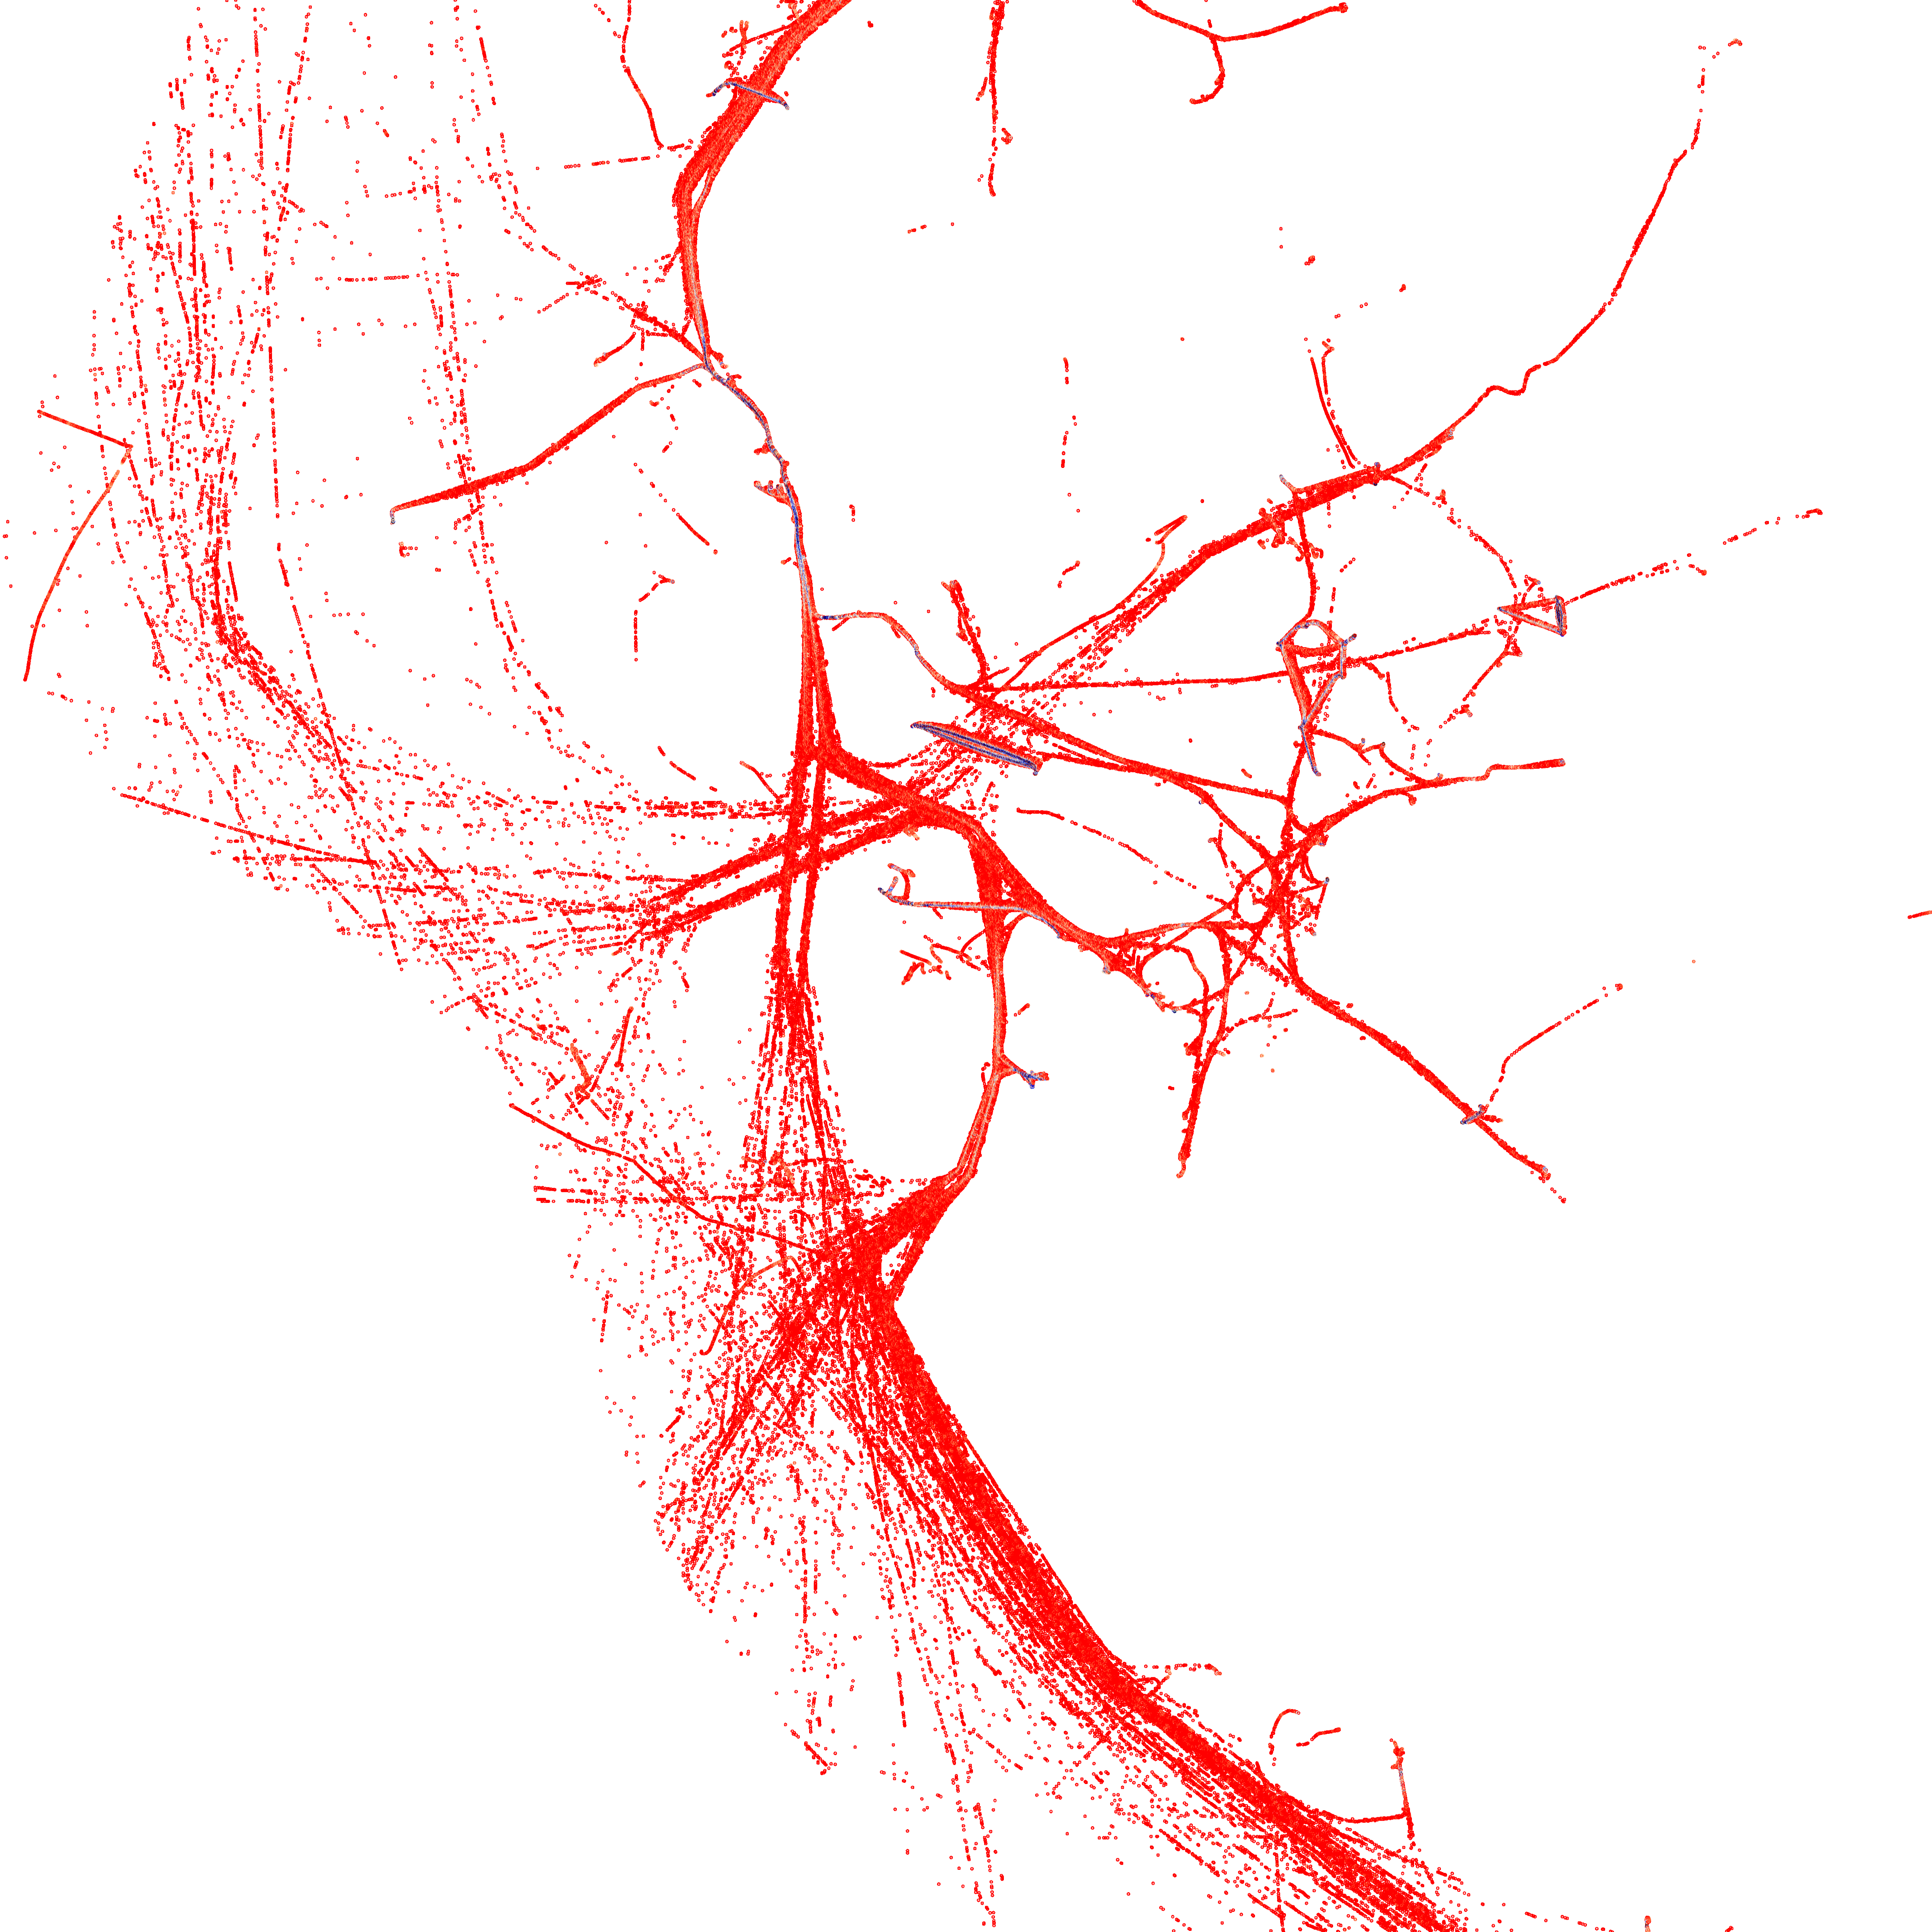

In [14]:
map = network.map_waypoints()
map = waypoint_connections[waypoint_connections.passages>5].explore(m=map)
#map = network.map_graph(pruned=True)
#map = visualize.map_accurate_and_simplified_trajectory(trajectory, DP_trajectory, map=map)
map = DP_trajectories[DP_trajectories.mmsi.isin(mmsi)][['geometry', 'mmsi']].explore(m=map, color='black')
map = DP_points[DP_points.clusterID >= 0][['geometry', 'clusterID', 'mmsi']].explore(m=map, color='pink')
#map = wpts[wpts.clusterID.isin(cluster_list)][['convex_hull', 'clusterID']].explore(m=map, name='passed clusters', legend=False,
#                                              style_kwds={'color':'yellow', 'fillColor':'yellow', 'fillOpacity':0.2})
folium.LayerControl().add_to(map)
map